In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import itertools
from tqdm import tqdm

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)

sys.path.append("..")

from deprecated_repeating_classifier_training_utils import *

In [2]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [3]:
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

new_locs = []

new_titles = []

old_locs = ['/home/jtindall/presentation_links/20200724_164640_nomichel_3class',
            '/home/jtindall/presentation_links/20200730_151851_barrel_fix_only_3class',
            '/home/jtindall/presentation_links/20200729_125923_transforms_3class_rerun'
           ]

old_titles = ['Previous', 
              'No Transforms',
              'Transforms'
         ]

"""
new_linecolor = [c[0],c[1],c[2],c[3],c[4],c[5],c[6],c[7],c[8],c[9]]
new_linestyle = ['--','--','--','--','--','--','--','--','--','--']

old_linecolor = [c[0],c[1],c[2],c[3],c[4],c[5],c[6],c[7]]
old_linestyle = [':',':',':',':',':',':',':',':']
"""

new_linecolor = [c[0],c[0],c[0],c[0],c[0],c[0],c[0],c[0],c[0],c[0]]
new_linestyle = ['--','--','--','--','--','--','--','--','--','--']

old_linecolor = [c[1],c[1],c[1],c[1],c[1],c[1],c[1],c[1],c[1],c[1]]
old_linestyle = [':',':',':',':',':',':',':',':',':',':']

locs = new_locs + old_locs
titles = new_titles + old_titles
linecolor = new_linecolor + old_linecolor
linestyle = new_linestyle + old_linestyle

idx_file_paths = ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_post_veto_nomichel_pe_idxs.npz'
                  for _ in range(len(locs))]

cut_names= [['fq_failed', 'fq_flag'] for _ in range(len(locs))]
cut_path = '/home/jtindall/indices/pointnet_cut_indices.npz'

npz_path = '/home/jtindall/presentation_links/Index_Storage'
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
index_dict = {value:key for key, value in LABEL_DICT.items()}

In [4]:
#fig = disp_multiple_learn_hist(locs,losslim=2.5,titles=titles,leg_font=15, title_font=15)

In [5]:
test_output = [load_test_output_pn(os.path.join(loc,'test_validation_iteration_dump.npz'),
                                   cut_path,
                                   np.load(idx_file_paths[i])['test_idxs'], cut_names[i])
               for i, loc in enumerate(locs)]


In [6]:
plot_outputs = test_output
plot_labels = titles

## Load FiTQuN

In [7]:
preferred_run_idx = 2
preferred_run = test_output[preferred_run_idx]

In [8]:
fq_rootfiles, fq_eventids, fq_flag, fq_scores, fq_mom, fq_labels = load_fq_output(os.path.join(npz_path,'fq_mapping_idxs.npz'), 
                                                                                  os.path.join(npz_path,'fq_failed_idxs.npz'), 
                                                                                  idx_file_paths[preferred_run_idx], 
                                                                                  '/home/jtindall/indices/pointnet_cut_indices.npz', 
                                                                                  cut_names[0])

In [9]:
print(len(fq_labels))

2066763


In [11]:
pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(fq_rootfiles))
pbar.start()
for i in range(len(fq_rootfiles)):
    assert re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]) == preferred_run['rootfiles'][i].split('/')[-1], print(fq_rootfiles[i])
    assert fq_eventids[i]-1 == preferred_run['eventids'][i]
    
    #print(re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]))
    #print(preferred_run['rootfiles'][i].split('/')[-1])
    #input()
    pbar.update(i)
pbar.finish()
assert len(preferred_run['rootfiles']) == fq_rootfiles.shape[0]
print("Success! We now have a FiTQun output set in the same order as the h5 test set")

Success! We now have a FiTQun output set in the same order as the h5 test set


## Compute ROCs

In [12]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'],output['labels'],
                                'rejection', index_dict,"e","gamma") for output in plot_outputs]
                             +
                            [prep_roc_data(-fq_scores,fq_labels,
                            'rejection', index_dict, "e","gamma")])

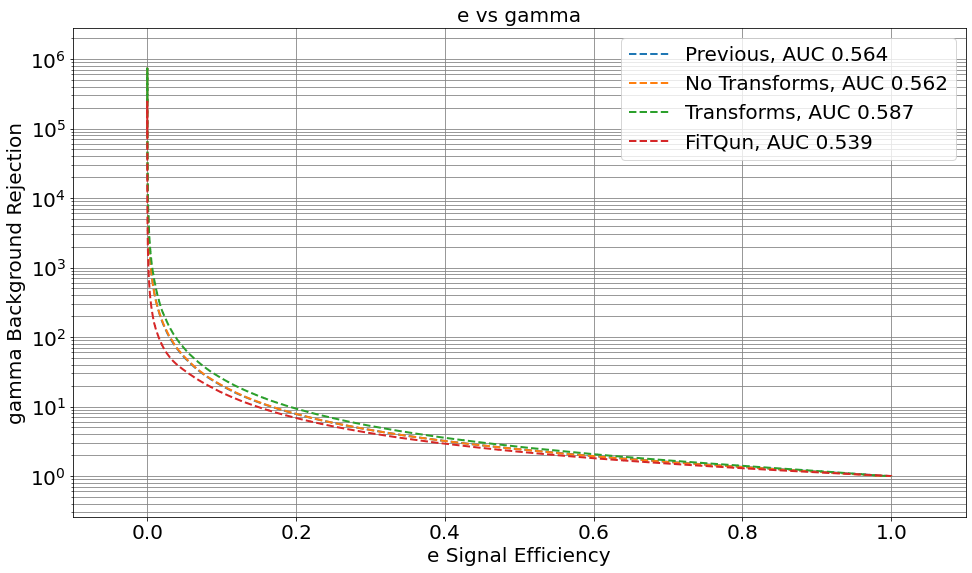

In [13]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "gamma"], 
                                plot_labels=plot_labels + ['FiTQun'], 
                                linestyle=linestyle,
                                title='e vs gamma',
                                annotate=False)

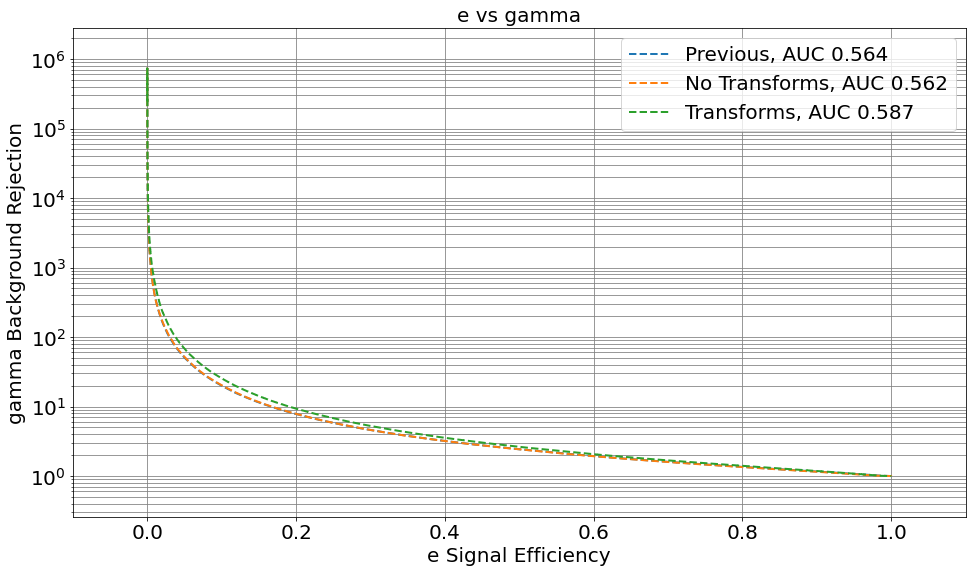

In [14]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'], output['labels'], 'rejection',
                                             index_dict, "e", "gamma") for output in plot_outputs])
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "gamma"], plot_labels=plot_labels,
                                png_name = 'overlaid_roc',title='e vs gamma',annotate=False,
                                linestyle=linestyle)

In [15]:
collapsed_info = [collapse_test_output(run['softmax'],run['labels'], index_dict, ignore_type="gamma") 
                  for run in test_output]

collapsed_scores = [info[0] for info in collapsed_info]
collapsed_labels = [info[1] for info in collapsed_info]

fprs, tprs, thresholds = zip(*[prep_roc_data(collapsed_scores[i],
                                             collapsed_labels[i], 
                                             'rejection', 
                                             index_dict, 
                                             "e","mu") for i in range(len(collapsed_info))]
                             +
                                [prep_roc_data(fq_scores,fq_labels,'rejection',index_dict,"e","mu")]
                            )

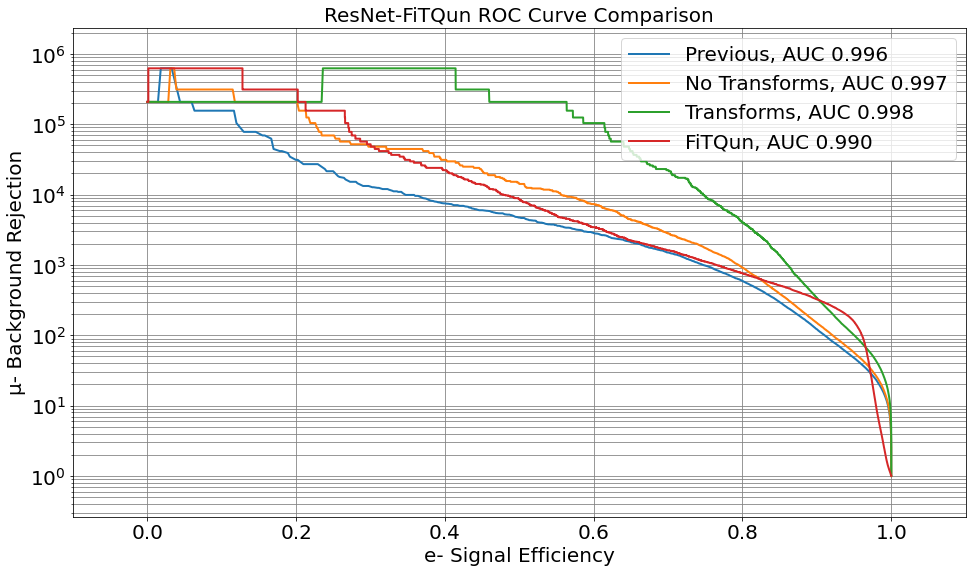

In [16]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),
                                'rejection', 
                                ["e", "mu"], 
                                plot_labels = plot_labels + ['FiTQun'],
                                title='ResNet-FiTQun ROC Curve Comparison',
                                annotate=False,
                                 xlabel='e- Signal Efficiency',
                                ylabel='\u03BC- Background Rejection'
                               )

In [17]:
collapsed_softmaxes, collapsed_labels = zip(
    *[collapse_test_output(output['softmax'], output['labels'], index_dict, ignore_type="gamma")
      for output in plot_outputs])

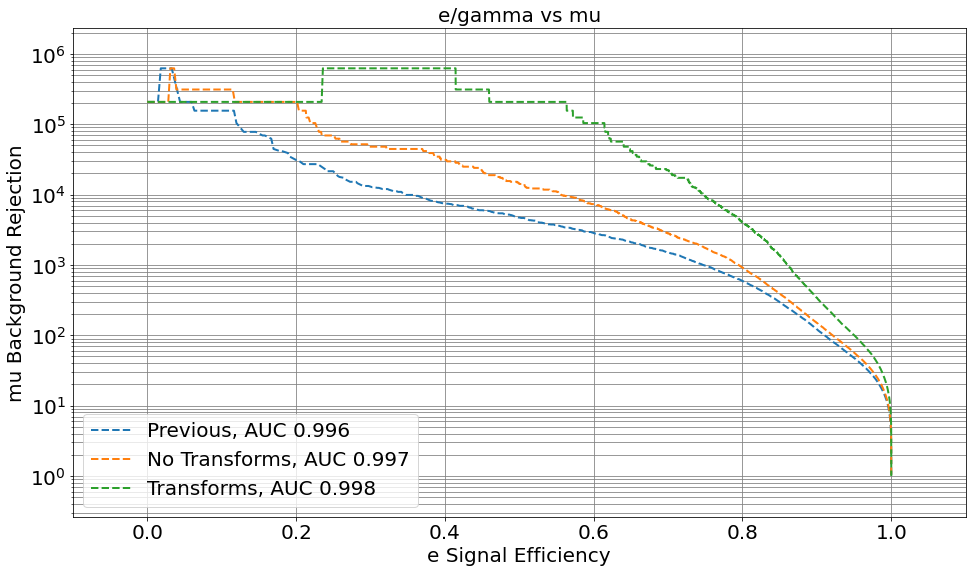

In [18]:
fprs, tprs, thresholds = zip(*[prep_roc_data(softmaxes, labels, 'rejection', index_dict, "e", "mu")
                               for softmaxes, labels in zip(collapsed_softmaxes, collapsed_labels)])
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "mu"],
                                plot_labels=plot_labels,
                                png_name = 'overlaid_roc',title='e/gamma vs mu',annotate=False,
                                linestyle=linestyle, leg_loc='lower left')